First of all, I am very keen on trying new methods. This is why I tried a meta-learning method in this project. In this technique, first I used a pretrained ViT (Vision Transformer) model for the feature extraction stage, then applied PCA for the curse of dimensionality problem, and finally used a tuned CatBoost model for the classification stage.


### ViT Model (for Feature Extraction) -> PCA (for Dimensionality Reduction) -> CatBoostClassifier (for Classification)

|                                 | Training Feature Shape |
|---------------------------------|-------------|
| ViT Features                    | (3038, 64)  |
| After PCA (99 % Variance Ratio) | (3038, 45)  |


I have used the following methods.

* I tried to implementation of distributed deep learning strategy,
* I split the full data into train (3038 images), validation (265 images) and test (367 images),
* I used a pretrained ViT model [1],
* Used <b>tf.data</b> for input pipeline,
* I used a tuned CatBoostClassifier model for classification (tuned with optuna),
* Shap for feature extraction,

## My Another Projects
* [Jellyfish Detect (10CV Custom ConvMixer) (F1:0.87)](https://www.kaggle.com/code/banddaniel/jellyfish-detect-10cv-custom-convmixer-f1-0-87)
* [(76 GB) 160 Polish Bird Sounds Classification](https://www.kaggle.com/code/banddaniel/76-gb-160-polish-bird-sounds-classification)
* [Segment Medical Instrument, w/Custom DeepLabv3+(Dice: 0.86)](https://www.kaggle.com/code/banddaniel/segment-medical-instrument-deeplabv3-dice-0-86)
* [Rice Classification w/Custom ResNet50 (ACC 85%)](https://www.kaggle.com/code/banddaniel/rice-classification-w-custom-resnet50-acc-85)
* [Lung Segmentation UNet w/SeparableConv (Dice:0.93)](https://www.kaggle.com/code/banddaniel/lung-segmentation-unet-w-separableconv-dice-0-93)


## References
1. https://github.com/faustomorales/vit-keras

In [1]:
from IPython.display import clear_output

!pip install vit_keras
!pip install shap
!pip install catboost
clear_output()

In [2]:
# Importing dependencies

import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from vit_keras import vit

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model

from catboost import CatBoostClassifier

import shap
shap.initjs()

IMG_SIZE = 256, 256
BATCH_SIZE = 32
SEED = 99
AUTO = tf.data.AUTOTUNE

In [3]:
# Creatin mirrored strategy and the model

stg = tf.distribute.MirroredStrategy()

# <span style="color:#e74c3c;"> Reading </span> Data

In [4]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = os.listdir(path)
    for i in images:
        full_path.append(os.path.join(path, i))
        
    return full_path


data_daisy = create_images_list('/kaggle/input/floral-diversity-a-collection-of-beautiful-blooms/flower_photos/daisy')
data_dandelion = create_images_list('/kaggle/input/floral-diversity-a-collection-of-beautiful-blooms/flower_photos/dandelion')
data_rose = create_images_list('/kaggle/input/floral-diversity-a-collection-of-beautiful-blooms/flower_photos/roses')
data_sunflower = create_images_list('/kaggle/input/floral-diversity-a-collection-of-beautiful-blooms/flower_photos/sunflowers')
data_tulip = create_images_list('/kaggle/input/floral-diversity-a-collection-of-beautiful-blooms/flower_photos/tulips')


# look-up table
flower_classes = {0:'daisy', 1 : 'dandelion', 2 : 'rose', 3 : 'sunflower', 4 : 'tulip'}


data_df = pd.concat([pd.DataFrame({"img" : np.array(data_daisy) , "label": 0 }),
                     pd.DataFrame({"img" : np.array(data_dandelion) , "label": 1 }),
                     pd.DataFrame({"img" : np.array(data_rose) , "label": 2 }),
                     pd.DataFrame({"img" : np.array(data_sunflower) , "label": 3 }),
                     pd.DataFrame({"img" : np.array(data_tulip) , "label": 4 }) ], ignore_index = True)


data_df = shuffle(data_df, random_state = SEED).reset_index(drop = True)
data_df.head()

,img,label
0,/kaggle/input/floral-diversity-a-collection-of...,0
1,/kaggle/input/floral-diversity-a-collection-of...,2
2,/kaggle/input/floral-diversity-a-collection-of...,2
3,/kaggle/input/floral-diversity-a-collection-of...,3
4,/kaggle/input/floral-diversity-a-collection-of...,4


# <span style="color:#e74c3c;"> Creating </span> Train, Validation and Test Sets

In [5]:
X_data, X_test, y_data, y_test = train_test_split(data_df['img'], data_df['label'], test_size = 0.1)
X_train, X_val, y_train, y_val = train_test_split(X_data,y_data, test_size = 0.08)

print("X_train shape -> ", X_train.shape[0])
print("X_val shape -> ", X_val.shape[0])
print("X_test shape -> ", X_test.shape[0])

X_train shape ->  3038
X_val shape ->  265
X_test shape ->  367


# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [6]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label


# Data augmentation 
def augmentation(image, label):
    img = tf.image.random_flip_left_right(image, seed = SEED)
    img = tf.image.random_flip_up_down(img, seed = SEED)
    img = tf.image.random_brightness(img, 0.1, seed = SEED)
    img = tf.image.random_contrast(img, 0.2, 0.4, seed = SEED)
    img = tf.image.random_saturation(img, 2, 6, seed = SEED)
    
    return img, label

In [7]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .map(augmentation, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE * 10)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))

train_loader_feature = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset_feature = (train_loader_feature
                         .map(img_preprocessing, num_parallel_calls = AUTO)
                         .batch(BATCH_SIZE)
                         .prefetch(AUTO))


valid_loader = tf.data.Dataset.from_tensor_slices((X_val, y_val))
valid_dataset = (valid_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))

test_loader = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = (test_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))

# <span style="color:#3498db;"> Feature Extraction </span>

# <span style="color:#e74c3c;">Pretrained ViT Feature Extractor </span> Model

In [8]:
from vit_keras import vit

with stg.scope():
    vit_model = vit.vit_b16( image_size = IMG_SIZE, activation = 'softmax', pretrained = True, include_top = False, pretrained_top = False, classes = 5)
    
    inp = Input(shape = (*IMG_SIZE, 3))
    vit = vit_model(inp)
    X = Flatten()(vit)
    X = Dense(64, activation = 'gelu', name = 'the_feature_layer')(X)
    X = Dense(32, activation = 'gelu')(X)
    out = Dense(5, activation = 'softmax')(X)

    model = Model(inputs = inp, outputs = out)
    model.summary()
    
    model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.0001,weight_decay = 0.0001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['acc',tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top_3_acc", dtype=None) ] )

347502902/347502902 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 the_feature_layer (Dense)   (None, 64)                49216     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                            

In [9]:
# Training feature extraction model and saved

hist = model.fit(train_dataset, epochs = 5, batch_size = 16, validation_data = valid_dataset)
model.save("vit_feature_extractor.h5")

Epoch 1/5
95/95 [==============================] - 190s 1s/step - loss: 0.4661 - acc: 0.8367 - top_3_acc: 0.9651 - val_loss: 0.1973 - val_acc: 0.9358 - val_top_3_acc: 0.9925
Epoch 2/5
95/95 [==============================] - 92s 966ms/step - loss: 0.1516 - acc: 0.9483 - top_3_acc: 0.9947 - val_loss: 0.1631 - val_acc: 0.9509 - val_top_3_acc: 0.9962
Epoch 3/5
95/95 [==============================] - 94s 984ms/step - loss: 0.0763 - acc: 0.9737 - top_3_acc: 0.9993 - val_loss: 0.1982 - val_acc: 0.9396 - val_top_3_acc: 0.9887
Epoch 4/5
95/95 [==============================] - 95s 996ms/step - loss: 0.0723 - acc: 0.9776 - top_3_acc: 0.9993 - val_loss: 0.1797 - val_acc: 0.9434 - val_top_3_acc: 0.9962
Epoch 5/5
95/95 [==============================] - 96s 1s/step - loss: 0.0509 - acc: 0.9835 - top_3_acc: 0.9997 - val_loss: 0.2520 - val_acc: 0.9283 - val_top_3_acc: 0.9962


In [10]:
# Validation and Test evaluations of ViT model

with stg.scope():
    val_eval_vit = model.evaluate(valid_dataset)
    print('Validation Loss: {0:.3f}'.format(val_eval_vit[0]))
    print('Validation Accuracy: {0:.3f} %'.format(val_eval_vit[1]*100))
    print('--'*50)
    test_eval_vit = model.evaluate(test_dataset)
    print('Test Loss: {0:.3f}'.format(test_eval_vit[0]))
    print('Test Accuracy: {0:.3f} %'.format(test_eval_vit[1]*100))

9/9 [==============================] - 3s 279ms/step - loss: 0.2520 - acc: 0.9283 - top_3_acc: 0.9962
Validation Loss: 0.252
Validation Accuracy: 92.830 %
----------------------------------------------------------------------------------------------------
12/12 [==============================] - 4s 291ms/step - loss: 0.1307 - acc: 0.9646 - top_3_acc: 1.0000
Test Loss: 0.131
Test Accuracy: 96.458 %


# <span style="color:#e74c3c;"> Classification </span> Stage

In [11]:
# Reading saved model and weights
feature_extr = tf.keras.models.load_model('/kaggle/working/vit_feature_extractor.h5')

# Feature extraction model 
feature_extractor_model = Model(inputs=feature_extr.input,
                                outputs=feature_extr.get_layer('the_feature_layer').output)

In [12]:
# Creating train features

with stg.scope():
    features = feature_extractor_model.predict(train_dataset_feature)

95/95 [==============================] - 37s 327ms/step


# <span style="color:#e74c3c;"> Dimensionality </span> Reduction

In [13]:
# Applying PCA 45 components nearly equal to 0.99 variance ratio

pca_ = PCA(45)
pred_pca_ = pca_.fit(features)
pred_pca = pred_pca_.transform(features)

new_feature_column_names = []
for i in range(pred_pca.shape[1]):
    new_feature_column_names.append('feature_{0}'.format(i+1))
    
train_features = pd.DataFrame(pred_pca, columns = new_feature_column_names)


# Features created with a pretrained ViT feature extractor 
train_features.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45
0,-8.248534,-8.531600,-3.452040,2.630104,1.031684,-1.069724,-0.426154,-0.147664,1.392253,0.602462,...,-0.246164,-0.667708,-0.085832,0.037599,0.598427,-0.107111,-0.218454,-0.405567,0.068162,0.029211
1,-4.284364,0.265128,4.562893,-3.924632,4.059850,0.069731,-1.789022,0.366109,-0.035849,0.648287,...,0.067177,0.269342,-0.468747,-0.468175,0.615685,-0.449427,-0.122713,0.213127,-0.248522,0.094227
2,15.462583,-2.825055,-0.033501,0.681218,-1.275594,0.071800,-0.557685,-0.103648,0.143476,-0.196634,...,-0.514793,-0.255552,0.194788,-0.288228,0.231440,-0.038133,-0.064554,0.092056,0.031894,-0.017713
3,-0.761686,6.222311,-7.717350,-6.038656,1.561269,-0.692485,-0.236071,0.264522,0.601642,-1.721126,...,-0.081923,-0.517817,0.434848,-0.331428,-0.201532,0.230260,0.053820,-0.104487,0.169397,0.019515
4,-2.123999,7.149764,-7.283179,-6.414532,-1.532562,-0.207910,0.193258,-0.025100,0.503125,-0.183948,...,0.194134,0.212762,-0.194157,0.213181,-0.522696,-0.543177,-0.196487,-0.628217,0.049790,-0.994298


# <span style="color:#e74c3c;"> Classification Catboost </span> Model

In [14]:
# a CatBoostClassifier model (tuned with optuna)

cat_model = CatBoostClassifier(iterations = 585, learning_rate = 0.006498635077055012, depth= 5, l2_leaf_reg = 0.012939079454134365,
                               bootstrap_type = 'Bayesian', random_strength =  2.6087541873590207e-06,
                               bagging_temperature = 5.249541483716103, od_type = 'IncToDec',od_wait = 38 ,verbose = 100)

cat_model.fit(train_features, y_train)

0:	learn: 1.5844430	total: 72.8ms	remaining: 42.5s
100:	learn: 0.5623096	total: 1.49s	remaining: 7.13s
200:	learn: 0.2740520	total: 2.9s	remaining: 5.53s
300:	learn: 0.1505350	total: 4.26s	remaining: 4.02s
400:	learn: 0.0900298	total: 5.63s	remaining: 2.58s
500:	learn: 0.0588344	total: 7.08s	remaining: 1.19s
584:	learn: 0.0451221	total: 8.2s	remaining: 0us


In [15]:
# Test set processing
# test feature exteaction -> applying PCA -> predictions of the catboost model

with stg.scope():
    test_pred = feature_extractor_model.predict(test_dataset)

test_pred_pca = pca_.transform(test_pred)
test_pred_pca = pd.DataFrame(test_pred_pca, columns = new_feature_column_names)


pred_cat_test = cat_model.predict(test_pred_pca)

12/12 [==============================] - 4s 309ms/step


# <span style="color:#e74c3c;"> Test  </span> Results

In [16]:
# Predictions and scores

mse = mean_squared_error(y_test, pred_cat_test)
f1 = f1_score(y_test, pred_cat_test, average = 'weighted')
acc = accuracy_score(y_test, pred_cat_test)

print('Mean Squared Error : {0:.5f}'.format(mse))
print('Weighted F1 Score : {0:.3f}'.format(f1))
print('Accuracy Score : {0:.3f} %'.format(acc*100))

Mean Squared Error : 0.16621
Weighted F1 Score : 0.962
Accuracy Score : 96.185 %


# <span style="color:#e74c3c;"> Test Classification </span> Report


In [17]:
clf = classification_report(y_test, pred_cat_test, target_names = list(flower_classes.values()))
print(clf)

              precision    recall  f1-score   support

       daisy       0.97      0.97      0.97        60
   dandelion       0.99      0.98      0.98        84
        rose       0.93      0.92      0.93        62
   sunflower       0.98      1.00      0.99        87
       tulip       0.93      0.93      0.93        74

    accuracy                           0.96       367
   macro avg       0.96      0.96      0.96       367
weighted avg       0.96      0.96      0.96       367



# <span style="color:#e74c3c;"> Test Confusion </span> Matrix

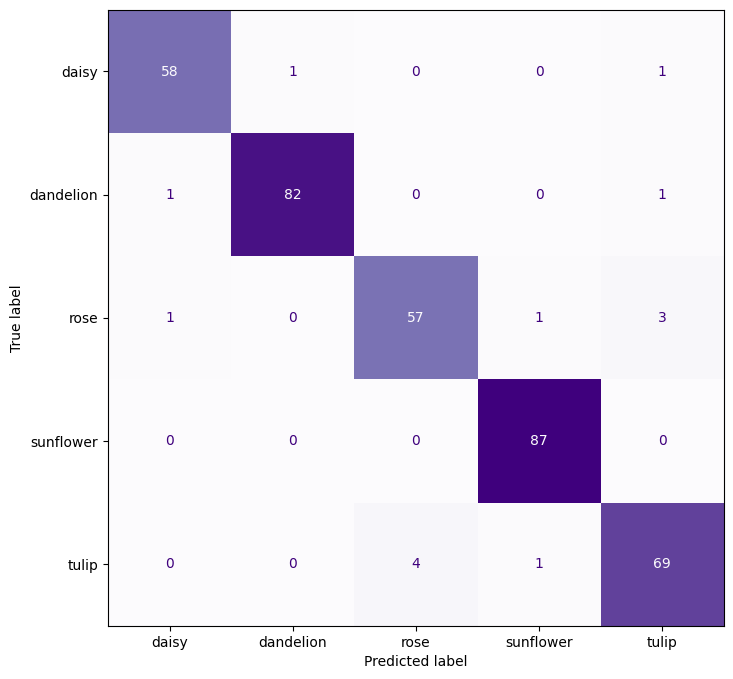

In [18]:
cm = confusion_matrix(y_test, pred_cat_test)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(flower_classes.values()))

fig, ax = plt.subplots(figsize=(8,8))
cmd.plot(ax=ax,  cmap = 'Purples', colorbar = False)

# <span style="color:#e74c3c;"> Test </span> Predictions

In [19]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)

# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(pred_cat_test))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        

        if int(pred_cat_test[idx[i]]) == label:
            axs[i].imshow(img, cmap = 'gray') 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + flower_classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img,  cmap = 'gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + flower_classes[label], fontsize = 8, color = 'red')

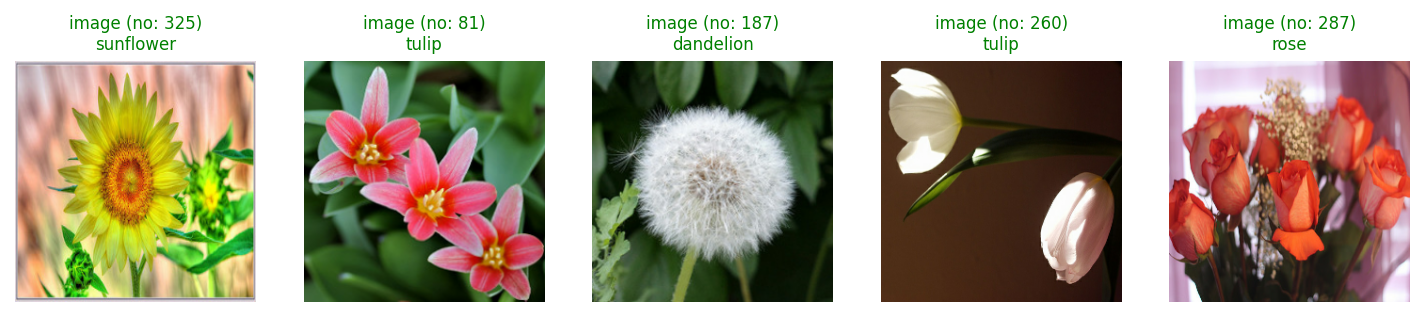

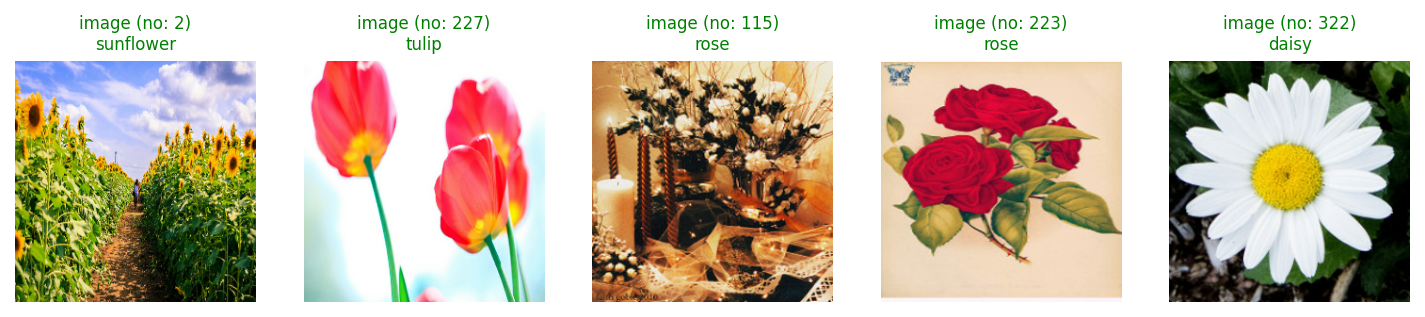

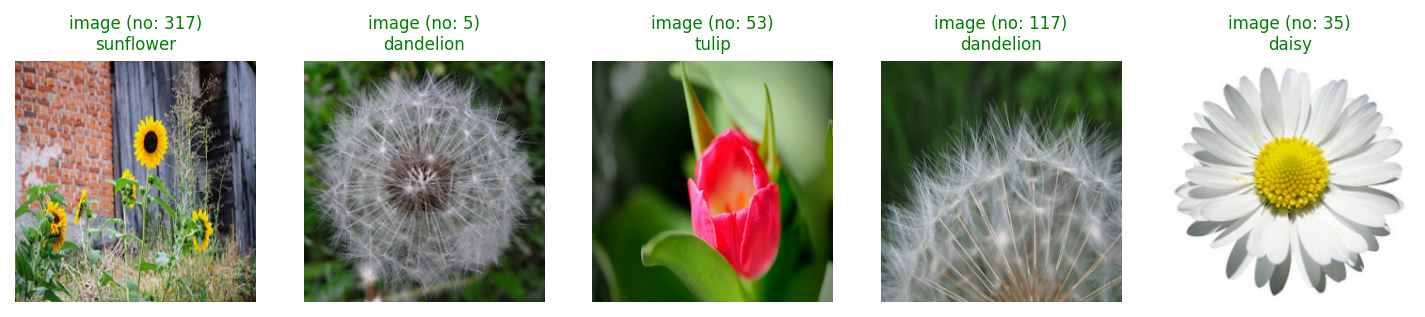

In [20]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(SEED = 20)
random_test_sample_with_prediction(SEED = 50)
random_test_sample_with_prediction(SEED = 99)

# <span style="color:#e74c3c;"> Feature Explanation </span> w/SHAP

In [21]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer(pd.DataFrame(test_pred_pca, columns = new_feature_column_names))

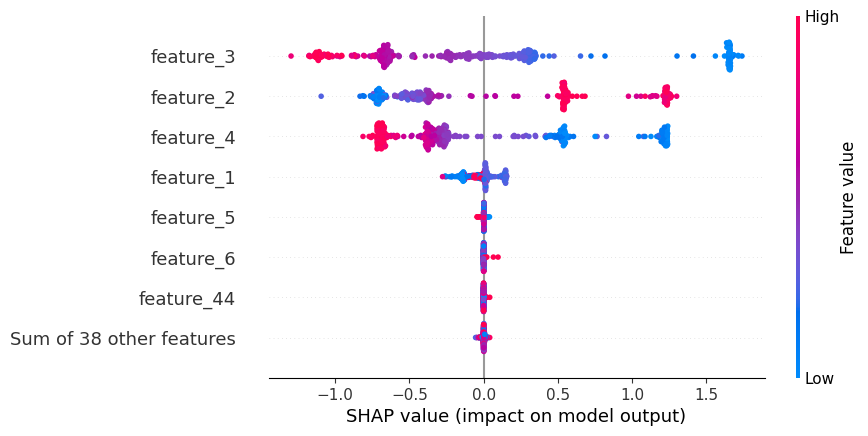

In [22]:
# daisy class feature explanation
shap.plots.beeswarm(shap_values[..., 0], max_display = 8)

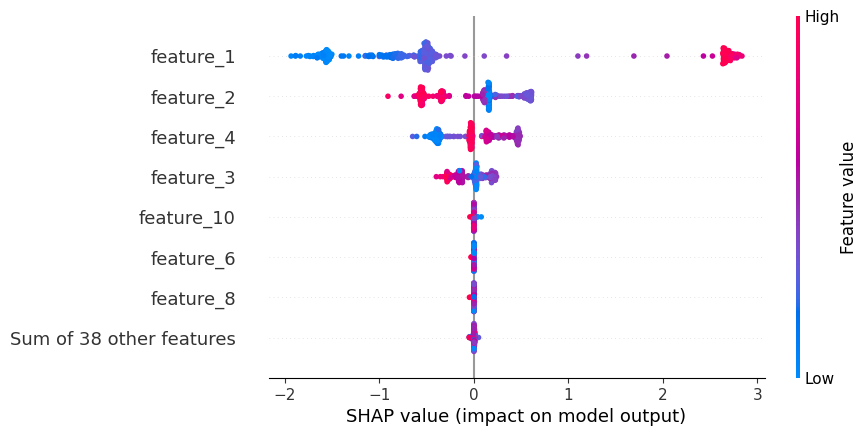

In [23]:
# dandelion class feature explanation
shap.plots.beeswarm(shap_values[..., 1], max_display = 8)

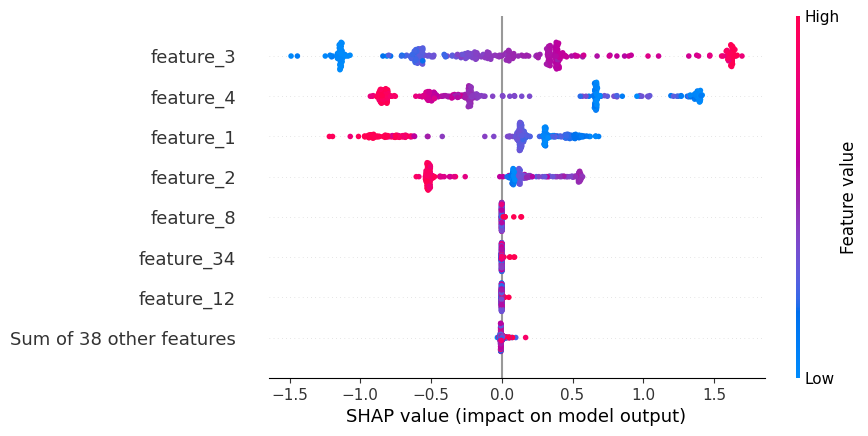

In [24]:
# rose class feature explanation
shap.plots.beeswarm(shap_values[..., 2], max_display = 8)

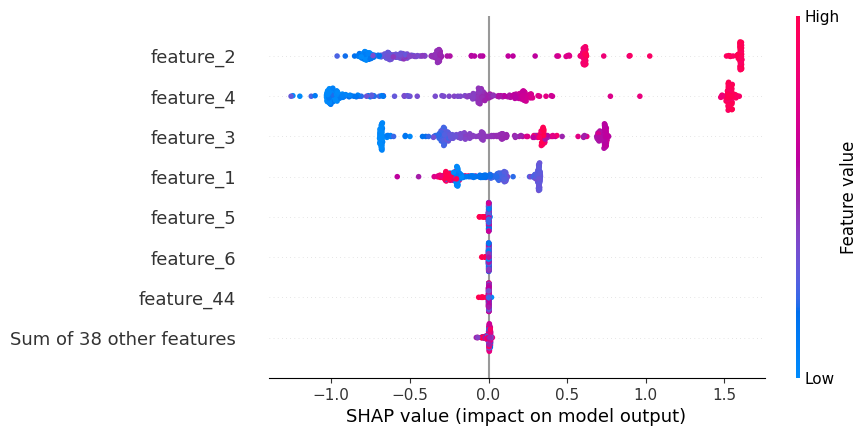

In [25]:
# sunflower class feature explanation
shap.plots.beeswarm(shap_values[..., 3], max_display = 8)

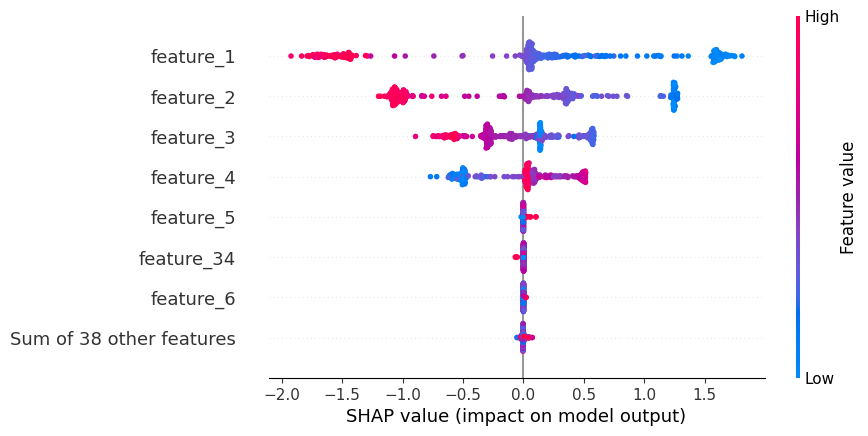

In [26]:
# tulip class feature explanation
shap.plots.beeswarm(shap_values[..., 4], max_display = 8)